In this example we will see how to plot an hexagonal map that reflects the results of the training process:

In [2]:
from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = np.genfromtxt('iris.csv', delimiter=',', usecols=(0, 1, 2, 3))
# data normalization
data = data - np.mean(data, axis=0)

target = np.genfromtxt('iris.csv', delimiter=',', usecols=(4), dtype=str)
t = np.zeros(len(target), dtype=int)
t[target == 'setosa'] = 0
t[target == 'versicolor'] = 1
t[target == 'virginica'] = 2

# Initialization and training
som = MiniSom(15, 15, 4, sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

som.train(data, 1000, verbose=True)

 [  837 / 1000 ]  84% - 0:00:00 left 

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.17125133433866352


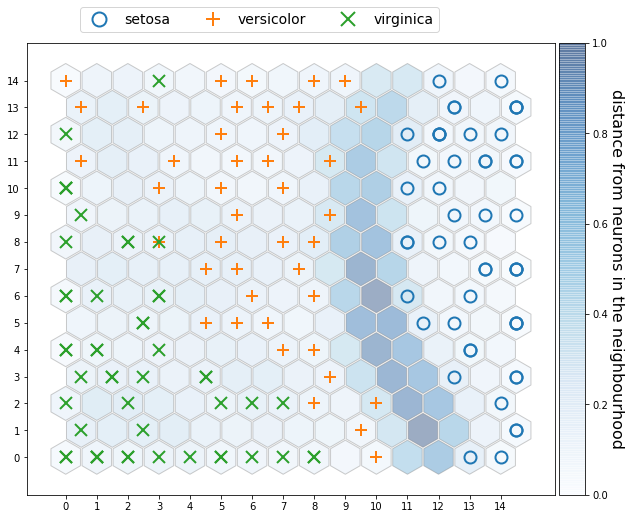

In [4]:
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)]*2/np.sqrt(3)*3/4
        hex = RegularPolygon((xx[(i, j)], wy), numVertices=6, radius=.95/np.sqrt(3),
                      facecolor=cm.Blues(umatrix[i, j]), alpha=.4, edgecolor='gray')
        ax.add_patch(hex)

markers = ['o', '+', 'x']
colors = ['C0', 'C1', 'C2']
for cnt, x in enumerate(data):
    w = som.winner(x)  # getting the winner
    # palce a marker on the winning position for the sample xx
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy*2/np.sqrt(3)*3/4
    plt.plot(wx, wy, markers[t[cnt]], markerfacecolor='None',
             markeredgecolor=colors[t[cnt]], markersize=12, markeredgewidth=2)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange*2/np.sqrt(3)*3/4, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

legend_elements = [Line2D([0], [0], marker='o', color='C0', label='setosa',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='+', color='C1', label='versicolor',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='x', color='C2', label='virginica',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left', 
          borderaxespad=0., ncol=3, fontsize=14)

plt.savefig('resulting_images/som_iris_hex.png')
plt.show()